# Alignment hypergraph to variant graph with networkx and masked arrays

Convert alignment hypergraph to variant graph before visualization.

1. Create alignment hypergraph as a list of hyperedge objects
1. Convert alignment hypergraph to numpy masked array
1. Create variant graph from masked array using networkx
1. Create graphviz SVG output from variant graph
1. Other visualizations will be created from the variant graph (as in current CollateX)

## Changelog

### 2021-11-02

1. Do not visualize original alignment graph (too large).
1. Instead, visualize variant graph without node-joining ("segmentation").
1. Perform node-joining of variant graph and visualize again.

### 2021-11-09

Alignment should be performed on vector space, not on alignment graph.

But: the alignment graph can merge hyperedges, so we need a function that operates on the vector space to merge vectors and delete unneeded old ones.

But: we can't delete a vector without forcing a copy, so we should zero it out instead. But then we'll have a lot of nulled rows that will complicate our processing, so …

So: Create a potential vector by itself in memory, determine whether it can be merged into an existing vector, and either merge or add, as needed. If we keep track of the tail position, we can allocate a large space initially, know how much of it is in use, and operate over a slice that includes only the vectors that contain real data.

## Initialize

In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext memory_profiler

import warnings
warnings.filterwarnings('ignore')

import gc # garbage collection
import operator # comparison operators lt and gt
from collections import defaultdict, deque
from typing import Set, List
from dataclasses import dataclass
import networkx as nx
import re
import time
import queue

import numpy as np
import numpy.ma as ma

import graphviz
from IPython.display import SVG

import pprint
pp = pprint.PrettyPrinter(indent=2)

debug = None

## Load data

In [2]:
%run create-blocks.ipynb # data will be in prioritized_blocks
print('aligning', how_many_paragraphs, 'paragraphs') # confirm

1 paragraphs from 6 witnesses
aligning 1 paragraphs


## Create data structures

1. Create witness_node (dataclass) for witness nodes. Properties (not all may be needed):
    1. token string: str
    1. witness: str
    1. offset in witness: int
    1. hyperedge: hyperedge instance (initially null)
    1. first_block: int (used for debugging, defaults to None)
1. Create alignment_hyperedge (dataclass) for … wait for it! … alignment hyperedges! Properties:
    1. witness_nodes: set of witness_node objects
1. Create lists for witness_node and alignment_hyperedge instances
1. Create START and END nodes and associated hyperedges

**TODO:** Can we abolish the alignment_hyperedge objects entirely, keeping all information in the vector space model?

In [3]:
@dataclass(unsafe_hash=True)
class WitnessNode:
    """TODO: Write a docstring some day"""
    token_string: str
    witness: str
    witness_offset: int
    hyperedge: hyperedge = None
    # first_block: int = None # TODO: Remove this?

    def __repr__(self):
        return self.token_string

# Subclass of WitnessNodeEnd so that our constructed end node will be able to identify itself
class WitnessNodeEnd(WitnessNode):
    """TODO: Write a docstring some day"""

In [4]:
# Store all witness nodes in dictionary of lists
witness_node_lists = defaultdict(list) # one per witness (keys will be sigla)
# create, for each witness:
#   nodes for real tokens
#   END node
# A start node is not created. That is on purpose.
for index, witness_siglum in enumerate(witness_sigla):
    # witness_sigla is a global set when the input data is read
    for witness_token_offset, witness_token in enumerate(witnesses[index]): # list of tokens in a single witness
        witness_node_lists[witness_siglum].append(WitnessNode(witness_token, witness_siglum, witness_token_offset))
    witness_node_lists[witness_siglum].append(WitnessNodeEnd('END', witness_siglum, len(token_array)))

In [5]:
def create_candidate_vectors(block):
    """Returns list of hyperedge data for block, one numpy array per hyperedge"""
    candidate_vectors = [] # list of individual vectors, not a matrix
    for token_offset_in_block in range(block.token_count):
        # first add the token_offset_in_block to the block start positions
        offset_start_positions = [value + token_offset_in_block for value in block.all_start_positions]
        tokens_to_place = [ # list of all token positions, not just first in each witness
            (
                token_membership_array[token_array_index],
                token_witness_offset_array[token_array_index]
            )
            for token_array_index in offset_start_positions
        ]

        data_for_new_vector = [0] * len(witness_sigla) # initialize to meaningless values
        mask_for_new_vector = [True] * len(witness_sigla) # we'll unmask individual values as needed
        for witness_number, witness_offset in tokens_to_place:
            data_for_new_vector[witness_number] = witness_offset
            mask_for_new_vector[witness_number] = False
        candidate_vectors.append(ma.MaskedArray(data=data_for_new_vector, mask=mask_for_new_vector))

    return candidate_vectors

In [6]:
if debug:
    a = create_candidate_vectors(prioritized_blocks[0]) # no masked values
    print(a)
    b = create_candidate_vectors(prioritized_blocks[800]) # perhaps some masked values; too lazy to check
    print(b)

In [7]:
def check_whether_okay_to_place(current_vectors, potential_vector) -> bool:
    """Return True iff we can add row without creating transpositions

    current_vectors: vector space before new addition
    potential_vector: we check whether this can be added

    If subtracting a potential vector from any existing vector would return
    values that diverge in sign, the potential would cross the existing one

    If it's okay to place, we need to call merge_vector() to see whether we
    should merge"""
    subtractionResult = current_vectors - potential_vector
    signs = np.sign(subtractionResult)
    okayToPlace = (signs.min(axis=1) == signs.max(axis=1)).all()
    if debug:
        print(f"{current_vectors=}")
        print(f"{potential_vector=}")
        print(f"{subtractionResult=}")
        print(f"{signs=}")
        print(f"{signs.min(axis = 1)}")
        print(f"{signs.max(axis = 1)}")
        print(f"{okayToPlace=}")
        print(f"{type(okayToPlace)=}")
    return True if okayToPlace is ma.masked else okayToPlace

In [8]:
def merge_vector(current_vectors, potential_vector):
    # a potential vector must contain two or more witnesses
    # vectors know their witness tokens, but witness tokens do not know their vector
    #
    # We've already determined that the vector is okay to place with check_whether_okay_to_place(),
    # and we now need to check for whether we should merge
    #
    # How many existing vectors already contain tokens on the potential vector?
    # There may be zero, one, or more existing vectors that contain tokens from the potential
    #
    found = [] # row numbers of vectors that match any witness in potential
    for row_number, row_vector in enumerate(current_vectors):
        comparison = row_vector - potential_vector
        if len(np.where(comparison == 0)).size > 0 : # check whether comparison (a vector) contains any 0 values
            found.append(row_number)

    if len(found) > 1:
        # found two or more existing vectors ...
        # remove them from the hyperedges set
        for index, row_number in enumerate(found):
            existing_vector = current_vectors[row_number]
            if debug==True:
                print("We are trying to the vector at row: " + str(row_number))
                print("Existing vector has witness offsets: " + str(existing_vector))
                print("Potential vector has witness offsets: " + str(potential_vector))
            # to mask out a row (assuming six columns):
            #   t = ma.MaskedArray(data = [0] * 6, mask=[True] * 6)
            # We keep first existing vector, merge others into it, and mask out others
            # np.logical_xor(t0.mask, t1.mask) returns True if one is masked, which are the ones we need to process
            # ma.MaskedArray(data=t0.filled(1) * t1.filled(1), mask=~np.logical_xor(t0.mask, t1.mask))
            #   keeps as unmasked only those where one value is masked and the other isn't
            if index == 0:
                pass # merge potential into first
            else:
                pass # merge current into first and mask current

            # NB: Siglum may be in both existing and potential; we assume (!) always
            #   with the same value
            # TODO (maybe): Should we override the keys method in Alignment_Hyperedge instead of checking _sigla?
            for siglum in existing_hyperedge._sigla: # don't get all keys, since that would include _sigla
                if siglum not in potential_hyperedge:
                    potential_hyperedge[siglum] = existing_hyperedge[siglum]
        # replace them by a new hyperedge
        hyperedges.append(potential_hyperedge)
        # update hyperedge property on the witness nodes involved in the hyperedge
        new_hyperedge = potential_hyperedge
        for witness_node in new_hyperedge.values():
            witness_node.hyperedge = new_hyperedge

    elif len(found) == 0:
        # we checked for transpositions
        # TODO: Can we filter out hyperedges we've already placed, so that we don't have to process them
        #   fully each time
        hyperedges.append(potential_hyperedge)
        # update hyperedge property on the witness nodes involved in the hyperedge
        new_hyperedge = potential_hyperedge
        for witness_node in new_hyperedge.values():
            witness_node.hyperedge = new_hyperedge
    else: # update single existing hyperedge
        for siglum in potential_hyperedge._sigla:
            list(found)[0][siglum] = potential_hyperedge[siglum] # add node to hyperedge (possibly redundantly)
            potential_hyperedge[siglum].hyperedge = list(found)[0] # and update hyperedge property of node

In [9]:
def process_blocks(selected_blocks):
    for index, selected_block in enumerate(selected_blocks):
        # Create hyperedges for entire block
        new_hyperedges = create_hyperedges(selected_block)
        # Check only first and last, merge is both are okay
        # NB: Checking only first and last to test entire block will break with discontinuous blocks
        #   (should we ever switch to working with discontinuous blocks)
        if index == 0:
            # add the first block without checking for transposition since matrix will be empty
            for potential_hyperedge in new_hyperedges:
                merge_hyperedge(potential_hyperedge)
        else:
            debug_flag = None
            no_transposition = check_whether_okay_to_place(hyperedges, new_hyperedges[0], debug_flag) and check_whether_okay_to_place(hyperedges, new_hyperedges[-1])
            if no_transposition: # all-or-nothing
                if debug:
                    print("Block #" + str(index) + " has no transposition")
                for potential_hyperedge in new_hyperedges:
                    merge_hyperedge(potential_hyperedge, debug=False)
            else:
                if debug:
                    print("Block #"+ str(index) + " (allegedly) has a transposition")

In [10]:
# create all hyperedges (gingerly)
# We exclude blocks with repetition (temporarily?)
selected_blocks = filter(lambda x: len(x.all_start_positions) == x.witness_count, prioritized_blocks)

# store all hyperedges in list
hyperedges = []

# %prun profiles; see https://towardsdatascience.com/magic-commands-for-profiling-in-jupyter-notebook-d2ef00e29a63
# %prun process_blocks(selected_blocks)
process_blocks(selected_blocks)

NameError: name 'create_hyperedges' is not defined

## Convert alignment graph to numpy masked array

In [11]:
vector_space_as_ma = convert_alignment_graph_to_numpy_masked_array(hyperedges, witness_sigla)

NameError: name 'convert_alignment_graph_to_numpy_masked_array' is not defined

## Create variant graph from alignment hypergraph

First create variant graph nodes. Walk over witness nodes in `witness_node_lists`. Keep track of which hyperedges have been added to variant graph. For each witness node:

1. If node has no hyperedge, create variant graph node with selected information from witness node on it.
1. If node has new hyperedge, create variant graph node with selected information from all witness nodes from hyperedge on it.
1. If node has hyperedge that is already on variant graph, do nothing.

Witness nodes contain token string, a witness siglum, a witness offset, and an optional hyperedge. The hyperedge contains, as dictionary items, all witness sigla as keys with witness nodes as values. From this information, we put onto the variant graph node the token string plus the hyperedge dictionary with sigla as keys and witness offsets as values.

**Notes:**

* The variant graph does not need to contain the token string, since we can look it up later, but for ease of visualization we include it here.
* In Real Life CollateX a variant graph node contains properties other than the token string. We ignore that structure in our experiment as we concentrate on visualization.

In [12]:
class VG_node():
    """Variant graph node"""
    def __init__(self, token_string, data): # dictionary of siglum:witness_offset
        self.token_string = token_string
        self.__dict__.update(**data)
        self._sigla = [key for key in data.keys()]
    def __repr__(self):
        return self.token_string + "~" + "|".join([":".join([str(key), str(getattr(self, key))]) for key in self.sigla()])
    def __setitem__(self, key, value):
        self._sigla.append(key)
        self.__dict__[key] = value
    def __getitem__(self, key):
        return self.__dict__[key]
    def __contains__(self, key):
        return key in self.__dict__
    def sigla(self):
        return self._sigla
    def values(self):
        return [self[key] for key in self._sigla]
    def items(self):
        return [(key, self.__dict__[key]) for key in self._sigla]

In [13]:
# Create networkx variant graph from our (not networkx) alignment graph
# Create variant graph edges for start and end nodes (only)
# We've treated VG as a global and we refer to it in the earlier functions; should we pass it instead?
def augment_or_add_edge_without_conversion(siglum, source_VG_node, target_VG_node):
    if VG.has_edge(source_VG_node, target_VG_node):
        VG[source_VG_node][target_VG_node]["siglum"].append(siglum)
    else:
        VG.add_edge(
            source_VG_node,
            target_VG_node,
            siglum = [siglum]
        )

In [14]:
# Use alignment graph node to look up variant graph node
def alignment_node_to_VG_node(alignment_node: WitnessNode) -> VG_node:
    global witness_offset_to_VG_node
    return witness_offset_to_VG_node[alignment_node.witness][alignment_node.witness_offset]

In [15]:
# Create variant graph data edges (except start and end nodes)
def augment_or_add_edge(siglum, source, target):
    source_VG_node = alignment_node_to_VG_node(source)
    target_VG_node = alignment_node_to_VG_node(target)
    if VG.has_edge(source_VG_node, target_VG_node):
        VG[source_VG_node][target_VG_node]["siglum"].append(siglum)
    else:
        VG.add_edge(
            source_VG_node,
            target_VG_node,
            siglum = [siglum]
                )

In [16]:
def create_variant_graph_from_vector_space():
    # create variant graph and add start and end nodes

    start_node = VG_node("START", {})
    end_node = VG_node("END", {})
    global VG # does this have to be global; we return it at the end, but we also use it in functions above
    VG = nx.DiGraph(start = start_node, end = end_node) # create start and end properties to find terminal nodes
    VG.add_node(start_node)
    VG.add_node(end_node)

    # keep track of which witness nodes (and therefore also hyperedges)
    # have been added to VG
    # does this duplicate information available from the following structure, since
    #   if we assign a value below to replace the None, this doesn't seem to add anything
    #   Can we get rid of this and use witness_offset_to_VG_node for this purpose instead?
    # NB: Includes START and END, which we will later ignore
    from bitarray import bitarray
    global VG_tracking # keep this, but should we return it instead of making it global?
    VG_tracking = {}
    for siglum, witness_node_list in witness_node_lists.items():
        VG_tracking[siglum] = bitarray(len(witness_node_list))
        VG_tracking[siglum].setall(0)

    # map from witness token node to variant graph node (needed to construct edges)
    # values will be added as we create variant graph nodes
    # NB: Includes START and END, which we will later ignore
    global witness_offset_to_VG_node # does this have to be global?
    witness_offset_to_VG_node = {}
    for siglum in witness_node_lists.keys():
        witness_offset_to_VG_node[siglum] = [None] * (len(witness_node_lists[siglum]))

    # Replaces old code in following cell to build variant graph,
    #   this time using vector space as main data source

    # 1. Convert vectors to variant graph nodes

    for row in vector_space_as_ma:
        if debug:
            print(' '.join(('Processing', str(row))))
        # create dictionary of siglum:value for node (variable name: data) and update globals
        data = {}
        for index, value in enumerate(row):
            if value != vector_space_as_ma.fill_value:
                siglum = 'w' + str(index)
                value = int(value)
                data[siglum] = value # add to eventually data for new VG node
                VG_tracking[siglum][value] = 1 # update global; do we need to adjust by 1?
        # get token string for node (variable name: token_string)
        siglum, offset = next(iter(data.items()))
        token_string = witness_node_lists[siglum][int(offset)].token_string
        # create and add new VG_node
        new_VG_node = VG_node(token_string, data)
        VG.add_node(new_VG_node)
        for siglum, offset in data.items(): # Eek! Another for loop! How embarrassing!
            witness_offset_to_VG_node[siglum][offset] = new_VG_node # update other global;

    # 2. Traverse variant graph (in arbitrary order), each of which contains witness nodes.
    #    Draw outgoing edges, which point to nodes with next tokens in each witness present
    #      on the variant graph node.
    #    Creating new variant graph nodes for witness tokens not in a hyperedge.
    #    Use queue because we're iterating over a dynamic structure (inventory of variant graph nodes).

    VG_node_queue = queue.Queue()
    #
    # Temporarily skipping START and END, which are the first two nodes
    #
    for node in VG.nodes(): # add all initial VG nodes to queue except START and END
        VG_node_queue.put(node)
        if debug:
            print(f"Adding node to VG_node_queue; length is {VG_node_queue.qsize()=}")
    ignore_start = VG_node_queue.get() # temporarily ignore START node when creating edges
    ignore_end = VG_node_queue.get() # temporarily ignore END node when creating edges
    if debug:
        print(f"Removed START and END; length is {VG_node_queue.qsize()=}")
    while not VG_node_queue.empty():
        if debug:
            print(f"Processing source node from VG_node_queue; length is {VG_node_queue.qsize()=}")
        source_node = VG_node_queue.get()
        targets = set()
        edge_labels = defaultdict(list) # key is target VG node, value is list of sigla
        sigla = source_node._sigla # all sigla on source node
        for siglum in sigla:
            # target may or may not already exist as node in VG
            source_offset = source_node[siglum]
            target_offset = source_offset + 1
            target = witness_offset_to_VG_node[siglum][target_offset]
            if target: # does the target already exist?:
                targets.add(target)
                edge_labels[target].append(siglum)
            else: # 1) create target, 2) add to targets, 3) add to queue of nodes, and 4 + 5) update globals
                # TODO: Do we need to update globals? We shouldn't need to return to nodes we add here.
                # NB: If real target object is of type WitnessNodeEnd, don't add it to the queue or create an edge
                # print(f"{type(witness_node_lists[siglum][target_offset])=}")
                witness_node_target = witness_node_lists[siglum][target_offset]
                if type(witness_node_target) != WitnessNodeEnd:
                    target_token_string = witness_node_target.token_string
                    new_VG_node = VG_node(target_token_string, {siglum: target_offset}) # 1 create target
                    targets.add(new_VG_node) # 2 add to targets
                    edge_labels[new_VG_node].append(siglum)
                    VG_node_queue.put(new_VG_node) # 3 add to queue of nodes
                    VG_tracking[siglum][target_offset] = 1 # 4 update first global
                    witness_offset_to_VG_node[siglum][target_offset] = new_VG_node # 5. update second global
        for target in targets:
            VG.add_edge(source_node, target, label=",".join(edge_labels[target]))
        #
        # Add edges for start VG nodes
        #
        all_first_data_nodes = defaultdict(list)
        for siglum in witness_sigla:
            key =  witness_offset_to_VG_node[siglum][0]
            all_first_data_nodes[key].append(siglum)
        for key,value in all_first_data_nodes.items():
            VG.add_edge(start_node, key, label=",".join(value))

        #
        # Add edges for end VG node
        #
        all_end_data_nodes = defaultdict(list)
        for siglum in witness_sigla:
            # Figure out why -2 works and clean up as needed
            key = witness_offset_to_VG_node[siglum][-2]
            all_end_data_nodes[key].append(siglum)
        for key,value in all_end_data_nodes.items():
            VG.add_edge(key, end_node, label=",".join(value))

    # we're done! return the result
    return VG

In [17]:
# # recover some memory
# del witness_node_list
# del witness_offset_to_VG_node
# del VG_tracking
gc.collect()
VG = create_variant_graph_from_vector_space()

8

NameError: name 'vector_space_as_ma' is not defined

## Visualize variant graph

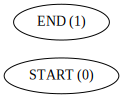

In [18]:
# # node id values must be strings for graphviz
a = graphviz.Digraph(format="svg", name="variant_graph_unjoined")
a.attr(rankdir = "LR")
a.attr(rank = 'same')
a.attr(compound='true')

# plot nodes, building {node: id} for lookup
node_to_id = {}
for index, node in enumerate(VG.nodes()):
    node_id = str(index)
    node_to_id[node] = node_id
    node_text = node.token_string + " (" + node_id + ")"
    a.node(node_id, label=node_text)

# plot edges
for edge in VG.edges(data=True):
    # edge is a three-item tuple: source, target, dictionary of properties
    a.edge(node_to_id[edge[0]], node_to_id[edge[1]], label=edge[2]["label"])

# print('aligning', how_many_paragraphs, 'paragraphs') # confirm
SVG(a.view())

In [19]:
#  This function joins the variant graph in place.
#  This function is a straight port of the Java version of CollateX.

def join(graph):
    processed = set()
    end = graph.graph["end"]
    queue = deque()
    for (_, neighbor) in graph.out_edges(graph.graph["start"]):
        queue.appendleft(neighbor)
    while queue:
        vertex = queue.popleft()
        out_edges = graph.out_edges(vertex)
        if len(out_edges) == 1:
            (_, join_candidate) = next(iter(out_edges))
            can_join = join_candidate != end and len(graph.in_edges(join_candidate)) == 1
            if can_join:
                join_vertex_and_join_candidate(graph, join_candidate, vertex)
                # we have merged join_candidate (tokens originally to the right) into vertex (tokens originally to the left)
                # (for now, join_candidate node and all of its edges are still there, and we need to remove edges before
                #   we can remove node, which we do in a for loop)
                #
                # RESUME HERE: both of the following branches are wrong, the first cryptically (it shows sigla, but not
                #   all sigla) and the second conspicuously
                #
                for (_, neighbor, data) in list(graph.out_edges(join_candidate, data=True)):
                    graph.remove_edge(join_candidate, neighbor)
                    if graph.has_edge(vertex, neighbor):
                        continue # TODO: this looks wrong
#                         graph[source][target]["siglum"].append(data["siglum"])
                    else:
#                         graph.add_edge(vertex, neighbor, siglum=data["siglum"])
                         graph.add_edge(vertex, neighbor,label=data["label"])
                graph.remove_edge(vertex, join_candidate)
                graph.remove_node(join_candidate)
                queue.appendleft(vertex)
                continue
        processed.add(vertex)
        for (_, neighbor) in out_edges:
            # FIXME: Why do we run out of memory in some cases here, if this is not checked?
            if neighbor not in processed:
                queue.appendleft(neighbor)


def join_vertex_and_join_candidate(graph, join_candidate, vertex):
    # Note: since there is no normalized/non normalized content in the graph
    # a space character is added here for non punctuation tokens

    if re.match(r'^\W', join_candidate.token_string):
        vertex.token_string += join_candidate.token_string
    else:
        vertex.token_string += (" " + join_candidate.token_string)
    # join_candidate must have exactly one token (inside a list); left item may have more
#     for siglum, token in join_candidate.tokens.items():
#         vertex.add_token(siglum, token[0])

In [20]:
# len(nx.algorithms.cycles.find_cycle(VG))

In [21]:
# nx.algorithms.cycles.find_cycle(VG)

In [22]:
join(VG)

In [23]:
# pp.pprint([edge for edge in VG.edges()])

aligning 1 paragraphs


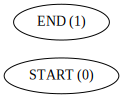

In [24]:
## node id values must be strings for graphviz
a = graphviz.Digraph(format="svg", name="variant_graph_joined")
a.attr(rankdir = "LR")
a.attr(rank = 'same')
a.attr(compound='true')

# plot nodes, building {node: id} for lookup
node_to_id = {}
for index, node in enumerate(VG.nodes()):
    node_id = str(index)
    node_to_id[node] = node_id
    node_text = node.token_string + " (" + node_id + ")"
    a.node(node_id, label=node_text)

# plot edges
for edge in VG.edges(data=True):
    # edge is a three-item tuple: source, target, dictionary of properties
#     label = "(all)" if len(edge[2]["siglum"]) == len(witness_sigla) else ",".join(sorted(edge[2]["siglum"]))
    label = edge[2]["label"]
    a.edge(node_to_id[edge[0]], node_to_id[edge[1]], label=label)

print('aligning', how_many_paragraphs, 'paragraphs') # confirm
SVG(a.view())

In [25]:
# for edge in VG.edges(data=True):
#     print(edge)

In [26]:
# nx.algorithms.cycles.find_cycle(VG)

# To do next

1. Move SVG/Graphviz code into function
1. Create alignment table visualization without joining
1. Add joining to the alignment table (to check accuracy of joining results)
1. Edge labels are wrong, which may be a problem with the join() function
1. Test intermediate data sets, larger than a paragraph and smaller than a chapter
1. Reassess method of prioritizing blocks
1. Implement decision tree / graph

In [27]:
# hyperedges

In [28]:
# len(hyperedges)

Unable to init server: Could not connect: Connection refused


In [29]:
# vector_space_as_ma.shape


(eog:1680): Gtk-WARNING **: 20:04:28.937: cannot open display: :0


In [30]:
# vector_space_as_ma

In [31]:
# for node in VG.nodes:
#     pp.pprint(node)

In [32]:
# pp.pprint(witness_offset_to_VG_node)